In [1]:
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from matplotlib import colors
from brain_block.random_initialize import connect_for_block, connect_for_multi_sparse_block
from brain_block.block import block
from analysis.spike_statistics import *
from scipy.ndimage import gaussian_filter1d
from scipy.io import loadmat
%matplotlib inline


In [5]:
def plot2d(data, xrange, yrange, emphasise_range=None, name="fr"):
    if emphasise_range is None:
        raise ValueError
    else:
        fig= plt.figure(figsize=(5, 3), dpi=300)
        ax = []
        ax.append(fig.add_axes([0.05, 0.1, 0.35, 0.8]))
        ax.append(fig.add_axes([0.5, 0.1, 0.35, 0.8]))
        ax.append(fig.add_axes([0.9, 0.25, 0.02, 0.5]))
    x, y = data.shape
    im = ax[0].imshow(data)  # norm=norm
    data = np.where(np.logical_and(data<=emphasise_range[1], data>=emphasise_range[0]), data, np.nan)
    ax[1].imshow(data)
    fig.colorbar(im, ax=[ax[0], ax[1]], cax=ax[2])
    for i in range(2):
        ax[i].grid(False)
        yticks = np.linspace(0, x, 4, endpoint=False, dtype=np.int8)
        ax[i].set_yticks(yticks)
        ax[i].set_yticklabels([f'{data:.1f}' for data in yrange[yticks]], rotation=60)
        xticks = np.linspace(0, y, 4, endpoint=False, dtype=np.int8)
        ax[i].invert_yaxis()
        ax[i].set_xticks(xticks)
        ax[i].set_xticklabels([f'{data:.1f}' for data in xrange[xticks]], )
    ax[0].set_ylabel(r"$AMPA$")
    ax[0].set_xlabel(r"$GABA_{A}$")
    ax[0].set_title(name)
    return fig

def arg_percentile(series, x):
    a, b = 0, 1
    while True:
        # m是a、b的终点
        m = (a+b)/2
        # 可以打印查看求解过程
        # print(np.percentile(series, 100*m), x)
        if np.percentile(series, 100*m) >= x:
            b = m
        elif np.percentile(series, 100*m) < x:
            a = m
        # 如果区间左右端点足够靠近，则退出循环。
        if np.abs(a-b) <= 0.000001:
            break
    return m


# load data (grid search d100)

In [3]:
file = np.load("../data/grid_search_d100.npz")


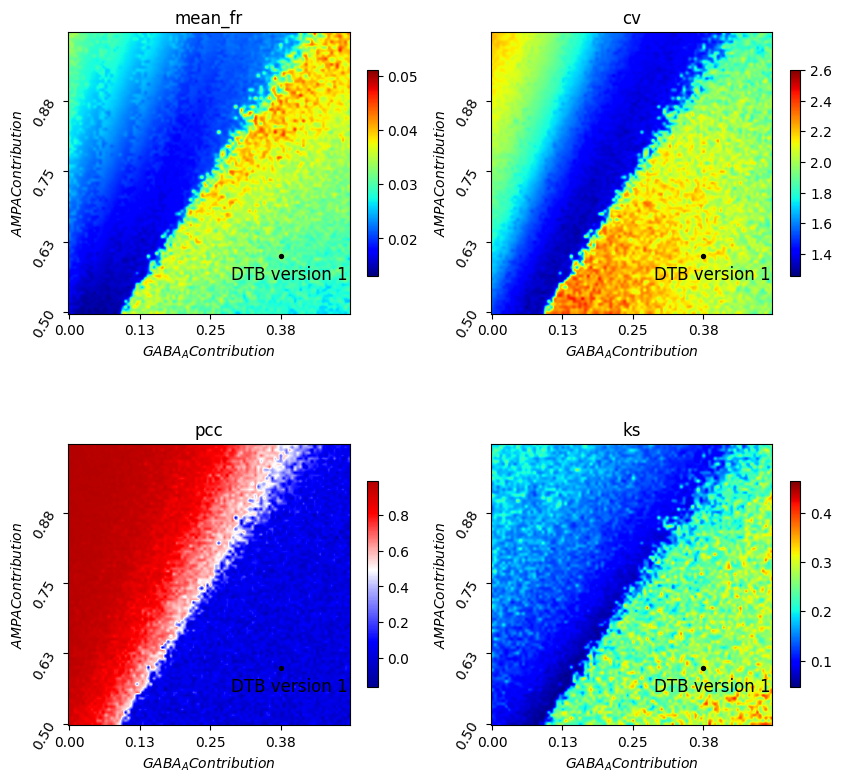

In [6]:
mean_fr = file["mean_fr"]
cv = file["cv"]
pcc = file["pcc"]
ks = file["ks"]
ampa_contribution = file["ampa_contribution"]
gabaA_contribution = file["gabaA_contribution"]
fig, ax = plt.subplots(2, 2, figsize=(10, 10), dpi=100)
ax = ax.flatten()
x, y = mean_fr.shape

im = ax[0].imshow(mean_fr, cmap='jet', interpolation='gaussian')
fig.colorbar(im, ax=ax[0], shrink=0.6)
ax[0].grid(False)
ax[0].set_title("mean_fr")

im = ax[1].imshow(cv, cmap='jet', interpolation='gaussian')
fig.colorbar(im, ax=ax[1], shrink=0.6)
ax[1].grid(False)
ax[1].set_title("cv")

pcc_data = pcc.flatten()
percent1 = arg_percentile(pcc_data, 0.2)
percent2 = arg_percentile(pcc_data, 0.8)
first = np.round(255*percent1).astype(np.int8)
second = np.round(255*(percent2 - percent1)).astype(np.int8)
third = 256 - first - second
#colors2 = new_cmap(np.linspace(0, 1, first))
colors1 = plt.cm.seismic(np.linspace(0.1, 0.42, first))
# colors2 = np.ones((second, 4), dtype=np.float64)
colors2 = plt.cm.seismic(np.linspace(0.42, 0.58, second))
colors3 = plt.cm.seismic(np.linspace(0.58, 0.9, third))
cols = np.vstack((colors1, colors2,colors3))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', cols)
im = ax[2].imshow(pcc, interpolation='bilinear', cmap=mymap)
fig.colorbar(im, ax=ax[2], shrink=0.6)
ax[2].grid(False)
ax[2].set_title("pcc")

im = ax[3].imshow(ks, cmap='jet', interpolation='gaussian')
fig.colorbar(im, ax=ax[3], shrink=0.6)
ax[3].grid(False)
ax[3].set_title("ks")


for i in range(4):
    ax[i].scatter([75], [20], marker="o", s=8, color="k")
    ax[i].text(0.58, 0.12, "DTB version 1", fontsize=12, transform=ax[i].transAxes)
    yticks = np.linspace(0, x, 4, endpoint=False, dtype=np.int8)
    ax[i].set_yticks(yticks)
    ax[i].set_yticklabels([f'{data:.2f}' for data in ampa_contribution[yticks]], rotation=60)
    xticks = np.linspace(0, y, 4, endpoint=False, dtype=np.int8)
    ax[i].invert_yaxis()
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels([f'{data:.2f}' for data in gabaA_contribution[xticks]], )
    ax[i].set_ylabel(r"$AMPA Contribution$")
    ax[i].set_xlabel(r"$GABA_{A} Contribution$")
fig.savefig("DTV_version1.png")


# Run Simulation


specified gui [0.0221331  0.0009899  0.12626262 0.02076319]
pcc 0.5494125740853657
remove
total done!
torch.Size([2000, 22]) torch.Size([4, 2000, 2000])
log.max 1


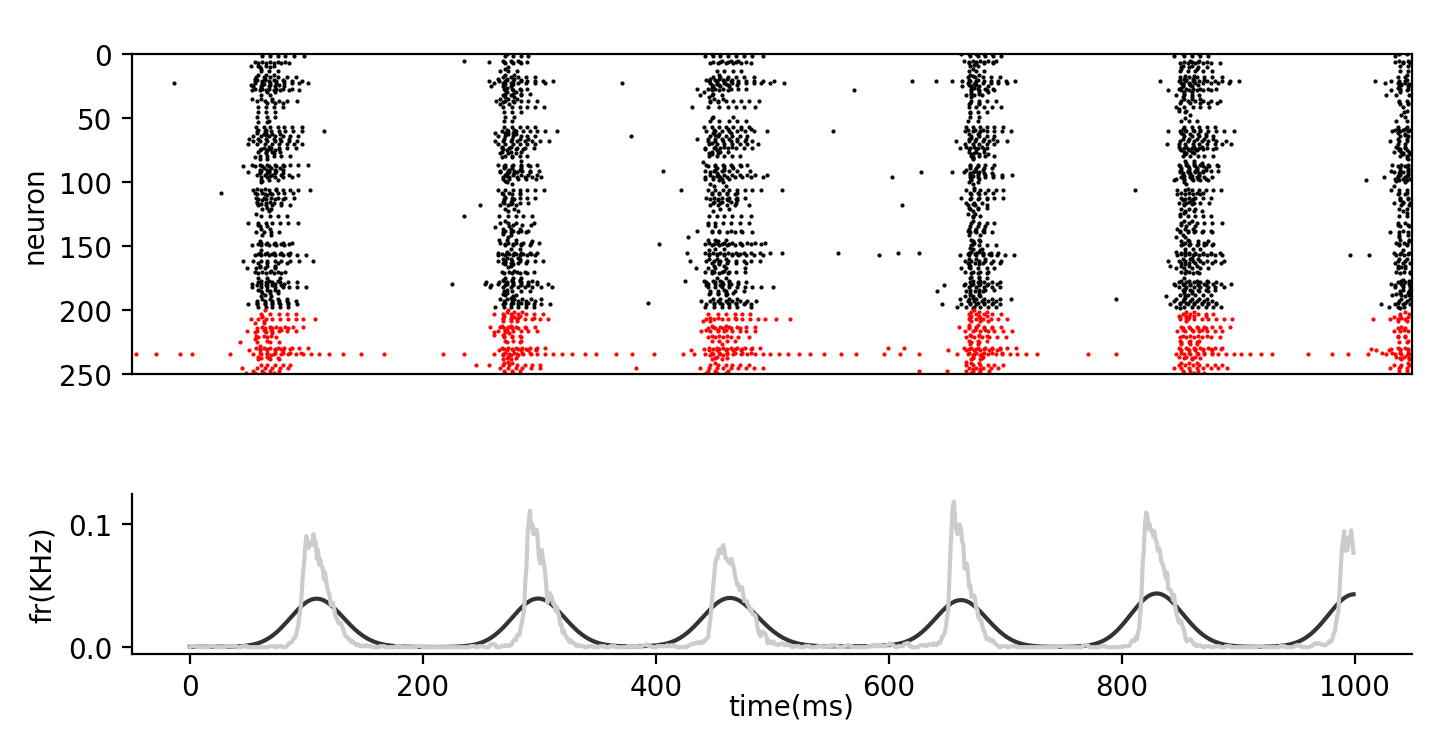

In [5]:
prob = torch.tensor([[1.]])
path = "small_block_d100"
tau_ui = (8, 40, 10, 50)

contribution = np.stack(np.meshgrid(ampa_contribution, gabaA_contribution, indexing='ij'), axis=-1).reshape(
    (-1, 2))
ampa_contribution = contribution[:, 0]
gabaA_contribution = contribution[:, 1]
ampa = ampa_contribution / 34
nmda = (1 - ampa_contribution) / 250
gabaA = gabaA_contribution / 2
gabaB = (1 - gabaA_contribution) / 36
para = np.stack([ampa, nmda, gabaA, gabaB], axis=1)
para = para.astype(np.float32)
specifcied_gui = para[50 * 100 + 50]
print("specified gui", specifcied_gui)
print("pcc", pcc_data[50 * 100+50])

if os.path.exists(os.path.join(path, 'single', 'block_0.npz')):
    print("remove")
    os.remove(os.path.join(path, 'single', 'block_0.npz'))
connect_for_multi_sparse_block(prob, {'g_Li': 0.03,
                                      'g_ui': specifcied_gui,
                                      "V_reset": -65,
                                        'tao_ui': tau_ui},
                               E_number=int(1.6e3), I_number=int(4e2), degree=100, init_min=0,
                               init_max=1, perfix=path)
property, w_uij = connect_for_block(os.path.join(path, 'single'))


property[:, 10:14] = torch.tensor(specifcied_gui)

property = property.cuda()
w_uij = w_uij.cuda()
B = block(
    node_property=property,
    w_uij=w_uij,
    delta_t=0.1,
)
log_all = []
for time in range(20000):
    print(time, end='\r')
    B.run(noise_rate=0.0003, isolated=False)
    if time >= 10000:
        log_all.append(B.active.data.cpu().numpy())
log_all = np.array(log_all, dtype=np.uint8)
log = log_all[:, 1400:1650]
log = log.reshape((-1, 10, 250))
sub_log = log.sum(axis=1)
# np.save(os.path.join(self.path, "log.npy"), sub_log)
print("log.max", log.max())
fr = instantaneous_rate(sub_log, bin_width=5)
rate_time_series_auto_kernel = gaussian_filter1d(fr, 20, axis=-1)
fig = plt.figure(figsize=(8, 4), dpi=200)
ax = fig.add_subplot(1, 1, 1, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.grid(False)
ax.set_xlabel('time(ms)')
ax = fig.add_axes([0.1, 0.4, 0.8, 0.5])
x, y = sub_log[:, :200].nonzero()
ax.scatter(x, y, marker='.', color="black", s=1)
x, y = sub_log[:, 200:].nonzero()
ax.scatter(x, y + 200, marker='.', color="red", s=1)
ax.set_xlim([0, 1000])
ax.set_ylim([0, 250])
ax.set_xticks([])
ax.set_ylabel('neuron')
ax.invert_yaxis()
ax.set_aspect(1)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.2])
ax.plot(rate_time_series_auto_kernel, color='0.2')
ax.plot(fr, color='0.8')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_ylabel("fr(KHz)")
torch.cuda.empty_cache()

